# 필수 파일 설치 및 파일 경로 설정


In [1]:
# 1. 필수 라이브러리 및 NumPy 버전 호환성 설정
!pip install -q timm albumentations opencv-python-headless pyyaml tqdm scikit-learn facenet_pytorch

In [2]:
# 2. 프로젝트 폴더 구조 생성
import os
os.makedirs('config', exist_ok=True)
os.makedirs('src', exist_ok=True)
os.makedirs('model', exist_ok=True)
os.makedirs('data', exist_ok=True)       # 대회(Target) 데이터용
os.makedirs('data_ffpp', exist_ok=True)  # FF++(Source) 데이터용
os.makedirs('test_data', exist_ok=True)
open('src/__init__.py', 'w').close()

print("✅ 환경 설정 및 폴더 생성 완료!")

✅ 환경 설정 및 폴더 생성 완료!


In [4]:
from google.colab import drive
drive.mount('/content/drive')
# 마운트 반드시 해주기.

Mounted at /content/drive


# 학습 자료 다운받기(필요없으면 생략)

In [ ]:
%%writefile download.py
# -*- coding: utf-8 -*-
""" Downloads FaceForensics++ and Deep Fake Detection public data release """
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join

# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original_youtube_videos': 'misc/downloaded_youtube_videos.zip',
    'original_youtube_videos_info': 'misc/downloaded_youtube_videos_info.zip',
    'original': 'original_sequences/youtube',
    'DeepFakeDetection_original': 'original_sequences/actors',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'DeepFakeDetection': 'manipulated_sequences/DeepFakeDetection',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceShifter': 'manipulated_sequences/FaceShifter',
    'FaceSwap': 'manipulated_sequences/FaceSwap',
    'NeuralTextures': 'manipulated_sequences/NeuralTextures'
    }
ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
                'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
                'NeuralTextures']
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-d', '--dataset', type=str, default='all',
                        help='Which dataset to download',
                        choices=list(DATASETS.keys()) + ['all']
                        )
    parser.add_argument('-c', '--compression', type=str, default='raw',
                        help='Which compression degree.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=None,
                        help='Select a number of videos number to download')
    parser.add_argument('--server', type=str, default='EU',
                        help='Server to download the data from.',
                        choices=SERVERS
                        )
    args = parser.parse_args()

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    if duration > 0:
        speed = int(progress_size / (1024 * duration))
    else:
        speed = 0
    if total_size > 0:
        percent = int(count * block_size * 100 / total_size)
    else:
        percent = 0
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        try:
            if report_progress:
                urllib.request.urlretrieve(url, out_file_tmp,
                                           reporthook=reporthook)
            else:
                urllib.request.urlretrieve(url, out_file_tmp)
            os.rename(out_file_tmp, out_file)
        except Exception as e:
            print(f"\nError downloading {url}: {e}")
            os.remove(out_file_tmp)
    else:
        # [수정] 이미 파일이 있으면 아무 메시지도 출력하지 않고 조용히 넘어감
        pass


def main(args):
    # TOS
    print('By running this script you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')

    # Extract arguments
    c_datasets = [args.dataset] if args.dataset != 'all' else ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
                suffix = 'info'
            download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists
        try:
            if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
                filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
                if 'actors' in dataset_path:
                    filelist = filepaths['actors']
                else:
                    filelist = filepaths['DeepFakesDetection']
            elif 'original' in dataset_path:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist += pair
            else:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist.append('_'.join(pair))
                    if c_type != 'models':
                        filelist.append('_'.join(pair[::-1]))
        except Exception as e:
            print(f"Error fetching filelist: {e}")
            continue

        if num_videos is not None and num_videos > 0:
            print('Downloading the first {} videos'.format(num_videos))
            filelist = filelist[:num_videos]

        # Server and local paths
        dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
        dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)
        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                print('Skipping original masks.')
                continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)

if __name__ == "__main__":
    args = parse_args()
    main(args)

Writing download.py


In [ ]:
# 1. 구글 드라이브 마운트 확인
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 저장 경로
OUTPUT_PATH = '/content/drive/MyDrive/FF_Data'

# --- [1] Real (진짜) 데이터 다운로드 (총 2,500개) ---
# 전략: FF++ 원본(1,000개) + 구글 DeepFakeDetection 원본(1,500개) 합치기

print("🟢 1-1. Real 데이터 (FF++ Youtube) 1,000개 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d original \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

# --- [2] Fake (가짜) 데이터 다운로드 (총 2,500개) ---
# 전략: FF++ 딥페이크(1,000개) + 구글 DeepFakeDetection 가짜(1,500개) 합치기

print("\n🔴 2-1. Fake 데이터 (FF++ Deepfakes) 1,000개 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d Deepfakes \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

print("\n✅ 전체 다운로드 완료!)
print(f"📂 저장 경로: {OUTPUT_PATH}")

🟢 1-1. Real 데이터 (FF++ Youtube) 1,000개 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/original_sequences/youtube/c40/videos
100% 1000/1000 [23:06<00:00,  1.39s/it]

🟢 1-2. Real 데이터 (DeepFakeDetection Actors) 1,500개 추가 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/original_sequences/actors/c40/videos
100% 363/363 [10:08<00:00,  1.68s/it]

🔴 2-1. Fake 데이터 (FF++ Deepfakes) 1,000개 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/manipulated_

In [6]:
# 다운로드 / 전처리된 데이터 위치 확인 코드
import os
import glob

# 1. 구글 드라이브 확인 (🔥 전처리된 얼굴 이미지 폴더)
drive_path = '/content/drive/MyDrive/FF_Data_Crop_Margin30'
colab_path = './data_ffpp'

print("🕵️ 데이터 위치 추적 중...")

# 구글 드라이브 검사 (이미지 기준)
if os.path.exists(drive_path):
    files = glob.glob(os.path.join(drive_path, '**', '*.jpg'), recursive=True)
    print(f"✅ 구글 드라이브에서 발견됨! ({len(files)}개 이미지)")
    print(f"   경로: {drive_path}")
    TARGET_PATH = drive_path
else:
    print(f"❌ 구글 드라이브에 없음 ({drive_path})")
    TARGET_PATH = colab_path

# 2. 만약 구글 드라이브에도 없다면?
if TARGET_PATH == colab_path:
    files = glob.glob(os.path.join(colab_path, '**', '*.jpg'), recursive=True)
    print(f"🧐 Colab 폴더 확인 결과: {len(files)}개 이미지 발견")

# 결론
if len(files) > 0:
    print(f"\n🎉 찾았다! 전처리된 얼굴 데이터는 여기에 있습니다:")
    print(f"   ➜ '{TARGET_PATH}'")
    print("\n👉 이제 config.yaml의 DATA_PATH를 이 경로로 설정하세요.")
else:
    print("\n🚨 비상! 어디에도 전처리된 데이터가 없습니다.")
    print("   전처리 단계가 정상적으로 끝났는지 다시 확인하세요.")


🕵️ 데이터 위치 추적 중...
✅ 구글 드라이브에서 발견됨! (19992개 이미지)
   경로: /content/drive/MyDrive/FF_Data_Crop_Margin30

🎉 찾았다! 전처리된 얼굴 데이터는 여기에 있습니다:
   ➜ '/content/drive/MyDrive/FF_Data_Crop_Margin30'

👉 이제 config.yaml의 DATA_PATH를 이 경로로 설정하세요.


# 데이터 전처리 과정 및 dataset.py 설정


In [8]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 138.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
# [단계 1] 전처리 코드: 동영상 -> 30% 여백 얼굴 이미지 생성
import cv2
import os
import glob
import numpy as np
import torch
from facenet_pytorch import MTCNN
from tqdm.auto import tqdm

# ==========================================
# [설정] 경로 및 옵션
# ==========================================
# 1. 원본 동영상들이 있는 폴더 (사용자 환경에 맞게 수정)
SOURCE_PATH = '/content/drive/MyDrive/FF_Data'

# 2. 얼굴 이미지를 저장할 폴더
DEST_PATH = '/content/drive/MyDrive/FF_Data_Crop_Margin30'

# 3. 옵션
IMG_SIZE = 384
FRAMES_PER_VIDEO = 10  # 영상당 몇 장 뽑을지

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MTCNN (얼굴 감지기) 로드
# margin=0으로 설정하고, 우리가 직접 수동으로 계산해서 자를 겁니다.
mtcnn = MTCNN(keep_all=False, select_largest=True, device=device, margin=0)

print(f"🚀 전처리 시작: {SOURCE_PATH} -> {DEST_PATH}")
os.makedirs(DEST_PATH, exist_ok=True)

# 동영상 파일 목록 가져오기
all_videos = []
for ext in ['mp4', 'avi', 'mov']:
    all_videos.extend(glob.glob(os.path.join(SOURCE_PATH, '**', f'*.{ext}'), recursive=True))

print(f"📹 발견된 동영상: {len(all_videos)}개")

success = 0
errors = 0

for video_path in tqdm(all_videos, desc="Processing"):
    try:
        # 저장 경로 생성 (원본 폴더 구조 유지)
        rel_path = os.path.relpath(video_path, SOURCE_PATH)
        file_name = os.path.splitext(os.path.basename(video_path))[0]
        save_dir = os.path.dirname(os.path.join(DEST_PATH, rel_path))
        os.makedirs(save_dir, exist_ok=True)

        # 이미 처리된 파일 스킵
        if os.path.exists(os.path.join(save_dir, f"{file_name}_frame_00.jpg")):
            continue

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames > 0:
            # 균등 간격으로 프레임 추출
            idxs = np.linspace(0, total_frames-1, FRAMES_PER_VIDEO, dtype=int)

            for i, idx in enumerate(idxs):
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret: continue

                # BGR -> RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # 얼굴 감지
                boxes, _ = mtcnn.detect(frame_rgb)

                if boxes is not None:
                    # -------------------------------------------------
                    # [핵심] 30% 마진 적용 로직
                    # -------------------------------------------------
                    box = boxes[0]
                    x1, y1, x2, y2 = [int(b) for b in box]

                    w = x2 - x1
                    h = y2 - y1

                    # 30% 여백 계산
                    pad_x = int(w * 0.3)
                    pad_y = int(h * 0.3)

                    # 좌표 확장 (이미지 밖으로 나가지 않게 max/min 처리)
                    new_x1 = max(0, x1 - pad_x)
                    new_y1 = max(0, y1 - pad_y)
                    new_x2 = min(frame_rgb.shape[1], x2 + pad_x)
                    new_y2 = min(frame_rgb.shape[0], y2 + pad_y)

                    # 자르기
                    face = frame_rgb[new_y1:new_y2, new_x1:new_x2]

                    # 리사이즈 및 저장
                    if face.size > 0:
                        face_resized = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                        # 다시 BGR로 변환해서 저장 (OpenCV 저장용)
                        save_path = os.path.join(save_dir, f"{file_name}_frame_{i:02d}.jpg")
                        cv2.imwrite(save_path, cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))
                        success += 1
        cap.release()

    except Exception as e:
        errors += 1
        continue

print(f"\n✅ 완료! 저장된 이미지: {success}장 / 실패 비디오: {errors}개")

🚀 전처리 시작: /content/drive/MyDrive/FF_Data -> /content/drive/MyDrive/FF_Data_Crop_Margin30
📹 발견된 동영상: 2662개


Processing:   0%|          | 0/2662 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
%%writefile src/dataset.py
import cv2
import torch
import numpy as np
import os
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DeepfakeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, is_train=True):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train   # 🔹 핵심 추가

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        image = self._load_data(path)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.float32)

    def _load_data(self, path):
        ext = os.path.splitext(path)[1].lower()

        # ==========================
        # Video 처리
        # ==========================
        if ext in ['.mp4', '.avi', '.mov', '.mkv', '.webm', '.flv']:
            try:
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                if frame_count > 0:
                    if self.is_train:
                        # ✅ 학습: 랜덤 프레임 (기존 로직 유지)
                        frame_idx = np.random.randint(0, frame_count)
                    else:
                        # ✅ 추론: 항상 동일한 프레임 (재현성 확보)
                        frame_idx = frame_count // 2

                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                    ret, frame = cap.read()
                    cap.release()

                    if ret:
                        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                cap.release()
            except Exception:
                pass

        # ==========================
        # Image 처리
        # ==========================
        elif ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp', '.jfif', '.heic']:
            try:
                img = cv2.imread(path)
                if img is not None:
                    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except Exception:
                pass

        # ==========================
        # Fallback
        # ==========================
        return np.zeros((384, 384, 3), dtype=np.uint8)


def get_transforms(img_size):
    """
    EfficientNet(tf.efficientnet 계열)에 맞춘 전처리
    - 과도한 기하학 변형 완화
    - JPEG 압축 기반 증강 유지
    - Normalize는 ImageNet 기준 유지 (안정성)
    """

    # ===============================
    # Train Augmentation
    # ===============================
    train_aug = A.Compose([
        # 1) Resize (고정 입력 크기)
        A.Resize(img_size, img_size),

        # 2) 기하학적 변형 (강도 완화)
        A.HorizontalFlip(p=0.3),
        A.Rotate(limit=8, p=0.2),
        A.Affine(
            scale=(0.95, 1.05),
            translate_percent=(0.03, 0.03),
            p=0.2
        ),

        # 3) 딥페이크 핵심 증강 (유지)
        A.ImageCompression(quality_range=(60, 100), p=0.3),
        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.3
        ),

        # 4) Normalize (ImageNet 기준, Train/Inference 통일)
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

    # ===============================
    # Validation / Inference
    # ===============================
    valid_aug = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

    return train_aug, valid_aug


Writing src/dataset.py


In [3]:
# 파일 실행을 위해 꼭 실행시켜주세요(파일이 있으면 실행 생략)
!touch src/__init__.py

# 모델 설정

In [26]:
%%writefile src/models.py
# src/models.py
import timm
import torch.nn as nn

class DeepfakeModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0
        )
        in_features = self.backbone.num_features
        self.head = nn.Linear(in_features, 1)

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)


Overwriting src/models.py


# 데이터 학습 설정



In [19]:
import os
import yaml

# 1. config 폴더가 없으면 생성 (에러 방지)
os.makedirs('config', exist_ok=True)

# 2. 설정 내용 작성 (EfficientNet + A100 최적화)
config_data = {
    'SEED': 42,
    'IMG_SIZE': 384,
    'BATCH_SIZE': 32,              # A100 GPU (40GB) 기준 최적값
    'EPOCHS': 15,                  # 20은 너무 깁니다. 10이면 충분합니다.
    'TARGET_DATA_COUNT': 10000,
    'LEARNING_RATE': 0.00001,
    'NUM_FRAMES' : 10,

    # [핵심] 우리가 사용하기로 한 모델
    'MODEL_NAME': 'tf_efficientnetv2_m.in21k_ft_in1k',

    # [중요] 학습 속도를 위해 아까 복사해둔 '로컬 경로' 사용
    # (드라이브 경로를 쓰면 0%에서 멈추는 병목현상 발생)
    'DATA_PATH': '/content/fast_data',

    'SAVE_PATH': './model/best_model_ffpp.pt'
}

# 3. 파일로 저장
with open('config/config.yaml', 'w') as f:
    yaml.dump(config_data, f)

print("✅ 설정 파일(config/config.yaml)이 정상적으로 생성되었습니다.")
print(f"📌 적용 모델: {config_data['MODEL_NAME']}")
print(f"📂 학습 데이터 경로: {config_data['DATA_PATH']} (고속 로컬 경로)")

✅ 설정 파일(config/config.yaml)이 정상적으로 생성되었습니다.
📌 적용 모델: tf_efficientnetv2_m.in21k_ft_in1k
📂 학습 데이터 경로: /content/fast_data (고속 로컬 경로)


아래는 실제 드라이브 => colab 폴더로 옮기는 과정입니다(시간 단축)

In [14]:
!mkdir -p /content/fast_data

In [15]:
!cp -r /content/drive/MyDrive/FF_Data_Crop_Margin30/* /content/fast_data/


# 학습 코드 설정

In [16]:
with open('src/__init__.py', 'w') as f:
    pass  # 내용은 없어도 됩니다. 파일이 존재하기만 하면 됩니다.

print("✅ src/__init__.py 생성 완료! 이제 빨간줄 에러가 사라질 겁니다.")

✅ src/__init__.py 생성 완료! 이제 빨간줄 에러가 사라질 겁니다.


In [20]:
%%writefile train.py
import os
import glob
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
import numpy as np

# 🚀 [A100 전용] 고속 연산 최적화
torch.backends.cudnn.benchmark = True

# 우리가 만든 모듈 불러오기
from src.dataset import DeepfakeDataset, get_transforms
from src.models import DeepfakeModel

with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

# =================================================
# 🔒 재현성 확보용 Seed 고정 (권장 수정 1)
# =================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# --- Focal Loss (어려운 샘플 집중 학습) ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss) if self.reduce else F_loss

# --- Mixup & CutMix (데이터 증강) ---
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(x.device)
    target_a, target_b = y, y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, target_a, target_b, lam

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🤖 Training Device: {device}")

    # 🔒 Seed 고정 적용
    seed_everything(CFG['SEED'])

    print(f"📂 학습 데이터 스캔 중: {CFG['DATA_PATH']}")
    all_files = glob.glob(os.path.join(CFG['DATA_PATH'], '**', '*.jpg'), recursive=True)

    real_paths, fake_paths = [], []

    for p in all_files:
        p_lower = p.lower()
        if 'original' in p_lower or 'real' in p_lower:
            real_paths.append(p)
        else:
            fake_paths.append(p)

    print(f"📊 데이터 검색 결과: Real {len(real_paths)} / Fake {len(fake_paths)}")

    if len(real_paths) == 0 or len(fake_paths) == 0:
        print("❌ 데이터가 부족합니다.")
        return

    # 데이터 수량 균형
    target_each = CFG['TARGET_DATA_COUNT'] // 2

    def adjust_data(paths, target_count):
        if len(paths) < target_count:
            repeat = (target_count // len(paths)) + 1
            paths = (paths * repeat)[:target_count]
        else:
            random.shuffle(paths)
            paths = paths[:target_count]
        return paths

    real_paths = adjust_data(real_paths, target_each)
    fake_paths = adjust_data(fake_paths, target_each)

    all_paths = real_paths + fake_paths
    labels = [0] * len(real_paths) + [1] * len(fake_paths)

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_paths, labels,
        test_size=0.2,
        random_state=CFG['SEED'],
        stratify=labels
    )

    train_tf, valid_tf = get_transforms(CFG['IMG_SIZE'])

    train_loader = DataLoader(
        DeepfakeDataset(train_paths, train_labels, train_tf, is_train=True),
        batch_size=CFG['BATCH_SIZE'],
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )

    val_loader = DataLoader(
        DeepfakeDataset(val_paths, val_labels, valid_tf, is_train=False),
        batch_size=CFG['BATCH_SIZE'],
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )

    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=True).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=float(CFG['LEARNING_RATE']), weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['EPOCHS'], eta_min=1e-7)
    criterion = FocalLoss(alpha=1, gamma=2)
    scaler = torch.cuda.amp.GradScaler()

    print(f"🔥 학습 시작 ({CFG['EPOCHS']} epochs)")
    best_loss = 1e9

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss, steps = 0, 0

        for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch}"):
            imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
            targets = targets * 0.9 + 0.05  # Label smoothing

            optimizer.zero_grad()

            r = random.random()
            if r < 0.25:
                imgs, ta, tb, lam = mixup_data(imgs, targets)
            elif r < 0.5:
                imgs, ta, tb, lam = cutmix_data(imgs, targets)
            else:
                ta, tb, lam = targets, targets, 1.0

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = lam * criterion(outputs, ta) + (1 - lam) * criterion(outputs, tb)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            steps += 1

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
                outputs = model(imgs)
                val_loss += criterion(outputs, targets).item()

        avg_train = train_loss / steps
        avg_val = val_loss / len(val_loader)

        print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f}")

        scheduler.step()

        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), CFG['SAVE_PATH'])
            print(f"✅ Best model saved ({best_loss:.4f})")

if __name__ == '__main__':
    train()

Overwriting train.py


In [21]:
!python train.py

🤖 Training Device: cuda
📂 학습 데이터 스캔 중: /content/fast_data
📊 데이터 검색 결과: Real 10998 / Fake 9990
🔥 학습 시작 (15 epochs)
Epoch 1: 100% 250/250 [00:48<00:00,  5.14it/s]
Epoch 1 | Train 0.1523 | Val 0.0951
✅ Best model saved (0.0951)
Epoch 2: 100% 250/250 [00:42<00:00,  5.82it/s]
Epoch 2 | Train 0.1129 | Val 0.0686
✅ Best model saved (0.0686)
Epoch 3: 100% 250/250 [00:42<00:00,  5.81it/s]
Epoch 3 | Train 0.1023 | Val 0.0514
✅ Best model saved (0.0514)
Epoch 4: 100% 250/250 [00:42<00:00,  5.83it/s]
Epoch 4 | Train 0.0950 | Val 0.0479
✅ Best model saved (0.0479)
Epoch 5: 100% 250/250 [00:43<00:00,  5.81it/s]
Epoch 5 | Train 0.0872 | Val 0.0439
✅ Best model saved (0.0439)
Epoch 6: 100% 250/250 [00:43<00:00,  5.79it/s]
Epoch 6 | Train 0.0824 | Val 0.0398
✅ Best model saved (0.0398)
Epoch 7: 100% 250/250 [00:43<00:00,  5.73it/s]
Epoch 7 | Train 0.0785 | Val 0.0372
✅ Best model saved (0.0372)
Epoch 8: 100% 250/250 [00:42<00:00,  5.81it/s]
Epoch 8 | Train 0.0834 | Val 0.0358
✅ Best model saved (0.0358

# 6. TEST용 파일 설치

In [22]:
import shutil
import os
import yaml

# 1. 구글 드라이브 -> 코랩 로컬로 데이터 복사 (약간 시간 걸리지만, 학습은 훨씬 빨라짐)
source_dir = '/content/drive/MyDrive/FF_Data_Crop' # 드라이브 경로
local_dir = '/content/fast_data'                   # 코랩 로컬 경로

print(f"🚀 데이터를 로컬({local_dir})로 복사 중... (잠시만 기다려주세요)")

# 폴더가 없으면 복사 시작
if not os.path.exists(local_dir):
    shutil.copytree(source_dir, local_dir)
    print("✅ 복사 완료! 이제 학습이 엄청 빨라질 겁니다.")
else:
    print("⚡ 이미 데이터가 로컬에 있습니다. 복사 생략.")

# 2. Config 파일의 경로를 '로컬 경로'로 수정
config_path = 'config/config.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)

# 경로 바꿔치기
config['DATA_PATH'] = local_dir

# 다시 저장
with open(config_path, 'w') as f:
    yaml.dump(config, f)

print(f"🔧 설정 변경 완료: DATA_PATH -> {local_dir}")

🚀 데이터를 로컬(/content/fast_data)로 복사 중... (잠시만 기다려주세요)
⚡ 이미 데이터가 로컬에 있습니다. 복사 생략.
🔧 설정 변경 완료: DATA_PATH -> /content/fast_data


In [23]:
import os
import shutil
import glob
from google.colab import drive

# 1. 경로 설정 (사용자님 드라이브 경로)
drive_path = '/content/drive/MyDrive/딥페이크 AI 대회/test.zip'
target_folder = './test_data'

# 2. 이미 데이터가 있는지 확인 (폴더가 있고, 파일이 하나라도 있으면 스킵)
if os.path.exists(target_folder) and len(os.listdir(target_folder)) > 0:
    print(f"✅ '{target_folder}' 폴더에 이미 데이터가 존재합니다.")
    print(f"📦 압축 해제 과정을 건너뜁니다. (파일 개수: {len(os.listdir(target_folder))}개)")

else:
    # ------------------ 기존 로직 시작 ------------------
    print("🚀 데이터가 없으므로 압축 해제를 시작합니다.")

    # 기존 폴더 정리 (혹시 빈 폴더거나 찌꺼기가 있을 수 있으므로)
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
    if os.path.exists('./temp_test'):
        shutil.rmtree('./temp_test')

    # 구글 드라이브 마운트
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    if os.path.exists(drive_path):
        print(f"✅ 구글 드라이브에서 파일을 찾았습니다! ({os.path.getsize(drive_path)/1024/1024:.2f} MB)")

        # 압축 풀기
        print("📦 압축 해제 중... (잠시만 기다려주세요)")
        !unzip -q "{drive_path}" -d ./temp_test

        # 파일 이동 준비
        os.makedirs(target_folder, exist_ok=True)

        # 검색할 확장자 리스트
        target_extensions = ['jfif', 'jpeg', 'jpg', 'mov', 'mp4', 'png']
        search_patterns = []

        for ext in target_extensions:
            search_patterns.append(f'*.{ext.lower()}')
            search_patterns.append(f'*.{ext.upper()}')

        print(f"검색할 확장자들: {search_patterns}")

        all_files = []
        for pattern in search_patterns:
            found = glob.glob(f'./temp_test/**/{pattern}', recursive=True)
            all_files.extend(found)

        print(f"총 {len(all_files)}개의 파일을 발견했습니다. 이동을 시작합니다...")

        # 파일 이동 실행
        for file in all_files:
            try:
                shutil.move(file, target_folder)
            except shutil.Error:
                pass # 중복 파일은 조용히 넘김
            except Exception as e:
                print(f"❌ 이동 실패: {file} - {e}")

        # 임시 폴더 삭제
        shutil.rmtree('./temp_test')

        final_count = len(os.listdir(target_folder))
        print(f"🎉 성공! {target_folder} 폴더 안에 총 {final_count}개의 파일이 준비되었습니다.")

    else:
        print(f"❌ '{drive_path}' 경로에 파일이 없습니다.")

🚀 데이터가 없으므로 압축 해제를 시작합니다.
✅ 구글 드라이브에서 파일을 찾았습니다! (1808.57 MB)
📦 압축 해제 중... (잠시만 기다려주세요)
검색할 확장자들: ['*.jfif', '*.JFIF', '*.jpeg', '*.JPEG', '*.jpg', '*.JPG', '*.mov', '*.MOV', '*.mp4', '*.MP4', '*.png', '*.PNG']
총 500개의 파일을 발견했습니다. 이동을 시작합니다...
🎉 성공! ./test_data 폴더 안에 총 500개의 파일이 준비되었습니다.


# 7. 추론 코드 저장 및 실행

In [37]:
%%writefile inference.py
import torch
import os
import pandas as pd
import numpy as np
import yaml
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from facenet_pytorch import MTCNN

from src.models import DeepfakeModel

# =================================================
# 설정
# =================================================
with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = CFG['SAVE_PATH']
TEST_DATA_PATH = './test_data'
OUTPUT_CSV = 'submission.csv'

# 동영상일 경우 분석할 프레임 수 (A100 기준 50장 가능)
FRAMES_PER_VIDEO = 50

class DeepfakeInferenceDataset(Dataset):
    def __init__(self, file_paths, img_size, device):
        self.file_paths = file_paths
        self.img_size = img_size
        self.mtcnn = MTCNN(keep_all=False, select_largest=True, device=device)
        self.transform = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        images = []

        try:
            # 🔥 [핵심 수정] 확장자 대신 파일 자체 속성을 확인
            # 일단 VideoCapture로 열어봅니다.
            cap = cv2.VideoCapture(path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # -----------------------------------------------------------
            # [CASE 1] 프레임이 2장 이상이다? -> 무조건 동영상 처리
            # -----------------------------------------------------------
            if frame_count > 1:
                # 50장 균등 추출
                frame_idxs = np.linspace(0, frame_count-1, FRAMES_PER_VIDEO, dtype=int)
                for frame_idx in frame_idxs:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                    ret, frame = cap.read()
                    if ret:
                        self._process_frame(frame, images)
                cap.release()

            # -----------------------------------------------------------
            # [CASE 2] 프레임이 1장 이하 or 못 읽음 -> 이미지로 시도
            # -----------------------------------------------------------
            else:
                cap.release()
                img = cv2.imread(path)
                if img is not None:
                    self._process_frame(img, images)

        except Exception as e:
            pass

        # 예외 처리: 만약 아무것도 못 건졌다면 블랙 이미지 1장
        if len(images) == 0:
            black = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            images.append(self.transform(image=black)['image'])

        # 결과 반환
        return torch.stack(images), os.path.basename(path)

    def _process_frame(self, frame, images_list):
        """프레임(이미지)에서 얼굴 찾고 전처리해서 리스트에 추가"""
        try:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # 얼굴 감지
            boxes, _ = self.mtcnn.detect(frame_rgb)

            if boxes is not None:
                box = boxes[0]
                x1, y1, x2, y2 = [int(b) for b in box]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(frame_rgb.shape[1], x2), min(frame_rgb.shape[0], y2)

                face = frame_rgb[y1:y2, x1:x2]
                if face.size > 0:
                    if self.transform:
                        face_tensor = self.transform(image=face)['image']
                        images_list.append(face_tensor)
            else:
                # 얼굴 없음 -> 중앙 크롭
                h, w = frame_rgb.shape[:2]
                c = min(h, w)
                face = frame_rgb[(h-c)//2:(h-c)//2+c, (w-c)//2:(w-c)//2+c]
                if self.transform:
                    face_tensor = self.transform(image=face)['image']
                    images_list.append(face_tensor)
        except:
            pass

def inference():
    print(f"🤖 Inference Device: {DEVICE}")

    if not os.path.exists(MODEL_PATH):
        return print(f"❌ 모델 파일 없음: {MODEL_PATH}")

    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=False).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    # 모든 파일 검색 (확장자 필터링 제거)
    file_list = []
    for root, dirs, files in os.walk(TEST_DATA_PATH):
        for file in files:
            if not file.startswith('.'):
                file_list.append(os.path.join(root, file))

    if not file_list: return print("❌ 파일 없음")

    dataset = DeepfakeInferenceDataset(file_list, CFG['IMG_SIZE'], DEVICE)
    # MTCNN 사용 시 멀티프로세싱(num_workers>0)은 에러 유발 가능성 있음 -> 0 추천
    test_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    preds = []
    filenames = []

    print(f"🚀 추론 시작 (동영상 감지 시 50장 / 이미지 1장)...")

    with torch.no_grad():
        for tensor_chunk, fname in tqdm(test_loader):
            tensor_chunk = tensor_chunk.squeeze(0).to(DEVICE)

            output = model(tensor_chunk)
            probs = torch.sigmoid(output).cpu().numpy().flatten()

            # ==========================================================
            # [점수 산출 전략]
            # 1. 여러 장이다 (동영상) -> Top 50% Mean (가짜 확률 높은 구간 평균)
            # 2. 한 장이다 (이미지) -> 그대로 사용
            # ==========================================================
            if len(probs) > 1:
                probs.sort()
                k = max(1, len(probs) // 2)
                score = np.mean(probs[-k:])
            else:
                score = probs[0]

            preds.append(score)
            filenames.append(fname[0])

    df = pd.DataFrame({'path': filenames, 'label': preds})
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ 결과 저장 완료")

if __name__ == '__main__':
    inference()

Overwriting inference.py


In [38]:
!python inference.py

🤖 Inference Device: cuda
🚀 추론 시작 (동영상 감지 시 50장 / 이미지 1장)...
  8% 40/500 [02:50<30:09,  3.93s/it][mjpeg @ 0x7c6d1c00] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x7c6d1c00] unable to decode APP fields: Invalid data found when processing input
 29% 144/500 [09:13<13:13,  2.23s/it][mjpeg @ 0x8f188480] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x8f188480] unable to decode APP fields: Invalid data found when processing input
 56% 279/500 [18:08<10:57,  2.98s/it][mjpeg @ 0x8c27e380] unable to decode APP fields: Invalid data found when processing input
100% 500/500 [34:22<00:00,  4.13s/it]
✅ 결과 저장 완료


# 8. 최종 확인.


📄 CSV 로드 완료: 500행

🟢 [Real] 진짜일 확률이 높은 (점수가 낮은) 상위 10개


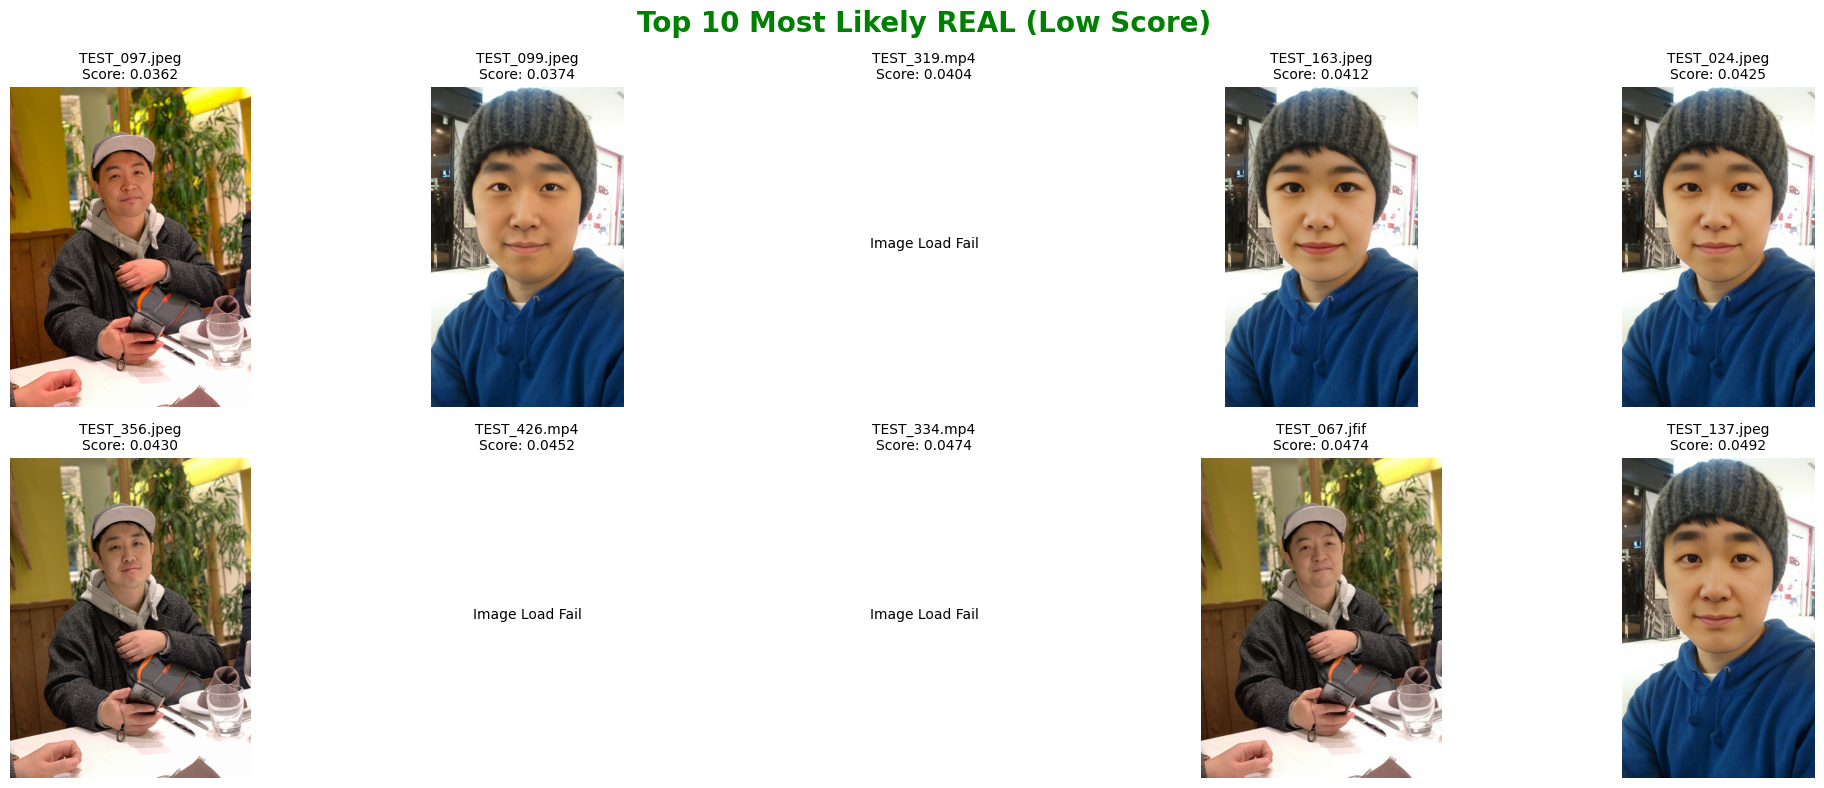


🔴 [Fake] 가짜일 확률이 높은 (점수가 높은) 상위 10개


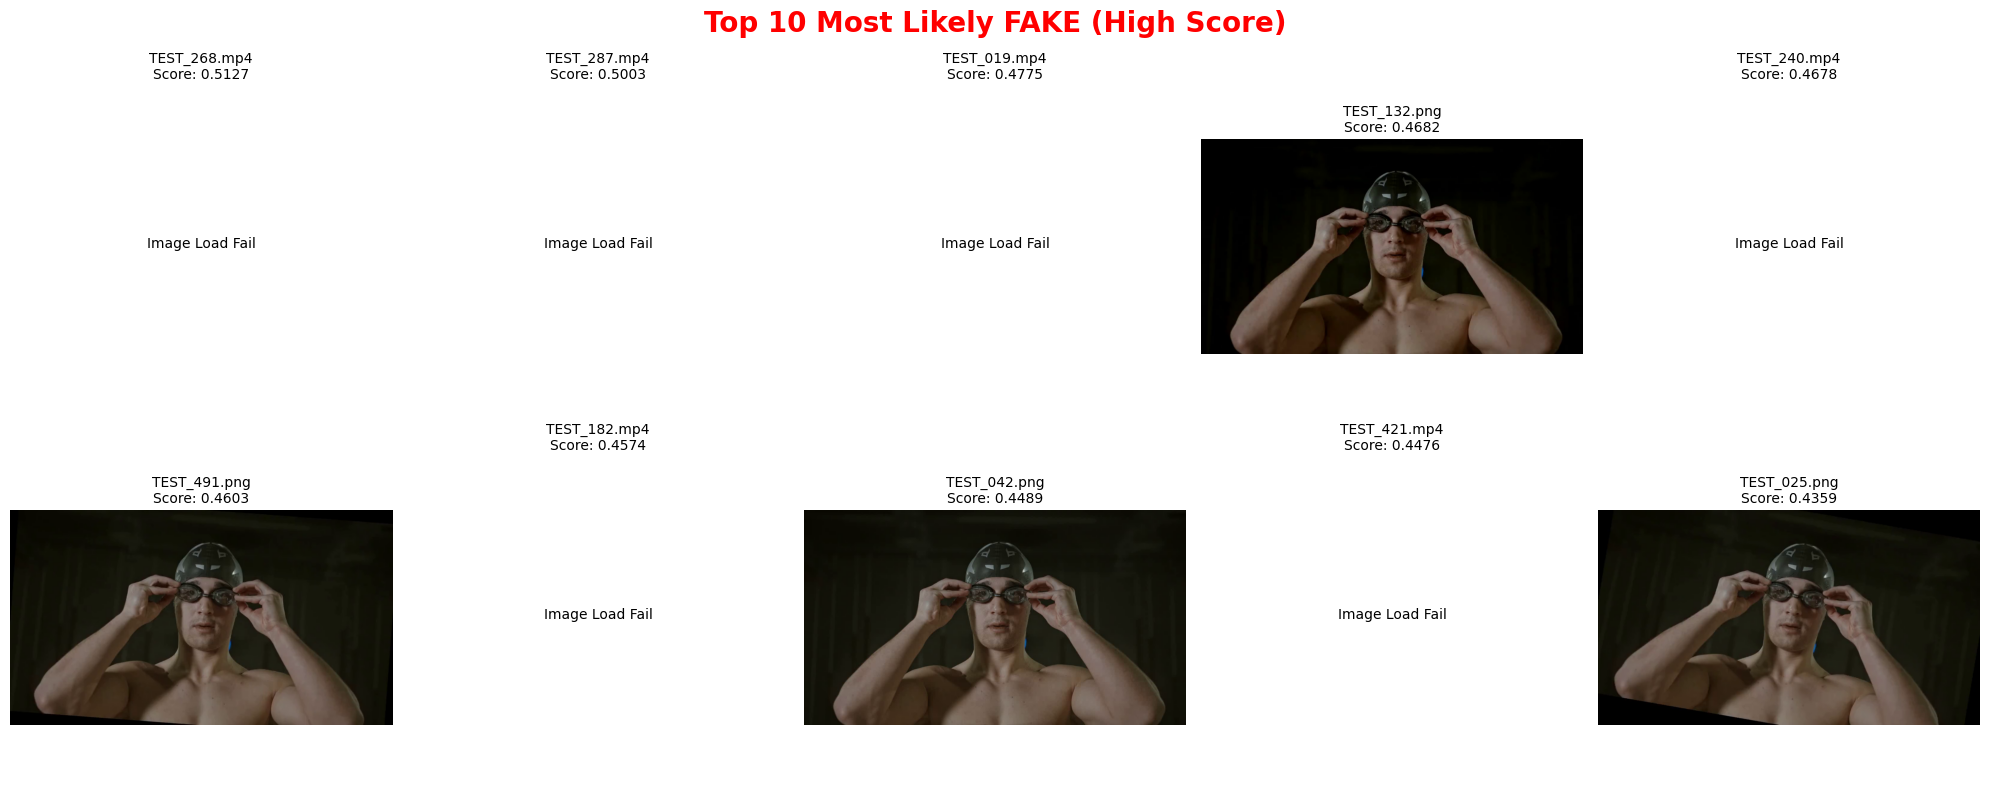

In [ ]:
import matplotlib.pyplot as plt
import cv2

# ==========================================
# 사용자 설정 (이 부분을 본인 상황에 맞게 수정하세요)
csv_path = 'submission.csv'   # 추론 결과 CSV 파일 경로
image_folder = './test_data'  # 이미지가 들어있는 폴더
id_col = 'filename'               # CSV에서 파일명이 적힌 컬럼 이름 (예: id, path, filename 등)
label_col = 'prob'           # CSV에서 확률/점수가 적힌 컬럼 이름 (예: label, pred, score 등)
# ==========================================

def visualize_top_images(df, sort_ascending, title, color):
    """
    df: 데이터프레임
    sort_ascending: True면 낮은 점수(Real 추정), False면 높은 점수(Fake 추정)
    title: 그래프 제목
    """
    # 정렬하여 상위 10개 추출
    top_10 = df.sort_values(by=label_col, ascending=sort_ascending).head(10)

    plt.figure(figsize=(20, 8))
    plt.suptitle(title, fontsize=20, color=color, weight='bold')

    for idx, (i, row) in enumerate(top_10.iterrows()):
        file_name = row[id_col]
        score = row[label_col]

        # 이미지 경로 결합 (CSV에 전체 경로가 있는지, 파일명만 있는지에 따라 다름)
        # 만약 CSV에 'test_data/abc.jpg' 처럼 폴더명까지 있다면 os.path.basename 사용 필요
        full_path = os.path.join(image_folder, os.path.basename(file_name))

        plt.subplot(2, 5, idx + 1)

        if os.path.exists(full_path):
            # 한글 경로 등이 있을 수 있으므로 opencv 대신 matplotlib image read 사용 권장될 수 있으나
            # 여기서는 cv2로 읽고 색상 변환
            img = cv2.imread(full_path)
            if img is None:
                plt.text(0.5, 0.5, 'Image Load Fail', ha='center')
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
        else:
            plt.text(0.5, 0.5, 'File Not Found', ha='center')

        plt.title(f"{os.path.basename(file_name)}\nScore: {score:.4f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 1. CSV 로드
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"📄 CSV 로드 완료: {len(df)}행")

    # 2. 진짜 같은 사진 (점수가 낮은 순, 0에 가까움)
    print("\n🟢 [Real] 진짜일 확률이 높은 (점수가 낮은) 상위 10개")
    visualize_top_images(df, sort_ascending=True, title="Top 10 Most Likely REAL (Low Score)", color='green')

    # 3. 가짜 같은 사진 (점수가 높은 순, 1에 가까움)
    print("\n🔴 [Fake] 가짜일 확률이 높은 (점수가 높은) 상위 10개")
    visualize_top_images(df, sort_ascending=False, title="Top 10 Most Likely FAKE (High Score)", color='red')

else:
    print(f"❌ CSV 파일을 찾을 수 없습니다: {csv_path}")
    print("추론(Inference) 코드를 먼저 실행하여 CSV 파일을 만들어주세요.")